In [1]:
!pip install EMD-signal
!pip install vnstock

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import PyEMD as pe
from vnstock import *

Observations:  1629
            Open  High   Low  Close   Volume Ticker
Time                                               
2017-06-02  3230  3330  3200   3280   411631    VND
2017-06-05  3320  3370  3270   3280   671582    VND
2017-06-06  3280  3320  3270   3320   174560    VND
2017-06-07  3320  3610  3320   3590  2332950    VND
2017-06-08  3640  3640  3510   3540   467477    VND
2017-06-09  3520  3660  3520   3560   726174    VND


<Axes: xlabel='Time'>

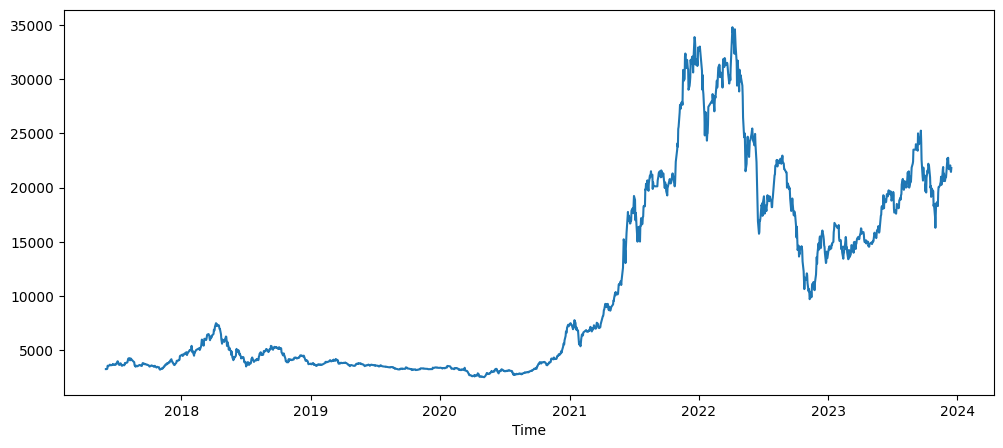

In [3]:
# Import data
VND = stock_historical_data(symbol = "VND", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VND['Close']))
print(pd.DataFrame(VND.head(6)))
train_dates = VND.index
plt.figure(figsize=(12, 5))
VND["Close"].plot()

In [4]:
VND = VND.reset_index(drop = True)
df = VND['Close']
df

0        3280
1        3280
2        3320
3        3590
4        3540
        ...  
1624    21950
1625    22050
1626    21600
1627    21450
1628    21800
Name: Close, Length: 1629, dtype: int64

In [5]:
## (A) CEEMDAN
#### 1. Thêm white noise vào chuỗi gốc s(t) thành chuỗi s1(t)
#### 2. Decompose chuỗi s1(t) bằng EMD ra các chuỗi IMF1 và Residue1
#### 3. Trung bình các chuỗi IMF1(t) thành mIMF1(t)
#### 4. r1(t) = s1(t) - mIMF1(t)
#### 5. Chuỗi mới s2(t) = r1(t) + coef*EMD(noise)
#### 6. Làm lại từ 1->5 đến khi chuỗi residue dừng

In [6]:
from PyEMD import EMD, CEEMDAN

In [7]:
ceemdan = CEEMDAN(range_thr=0.001, total_power_thr=0.01)
cIMFs = ceemdan.ceemdan(S=np.array(df.values), T= np.array(df.index))

In [8]:
pd.DataFrame(cIMFs.T, columns = ["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

,IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7
0,-52.918950,-55.732517,-62.101024,-75.371946,130.091669,-693.290423,4089.323191
1,-37.884820,-69.702640,-68.675314,-74.833703,146.480965,-701.690662,4086.306174
2,-64.248744,-33.472814,-50.315242,-68.884812,163.410658,-709.788192,4083.299147
3,87.711317,33.763601,-16.624391,-58.414644,180.840310,-717.578282,4080.302090
4,-27.215417,41.020084,19.809734,-44.601876,198.728694,-725.056202,4077.314983
...,...,...,...,...,...,...,...
1624,172.580646,-489.592281,-34.062420,2937.637219,-1642.037690,3603.605476,17401.869050
1625,288.589571,-414.864581,-148.438990,2971.537818,-1616.424626,3568.802412,17400.798397
1626,-162.561040,-350.433798,-212.995321,2980.305134,-1587.477957,3533.340142,17399.822841
1627,-322.689319,-316.234916,-215.135006,2963.089789,-1555.193464,3497.220801,17398.942113


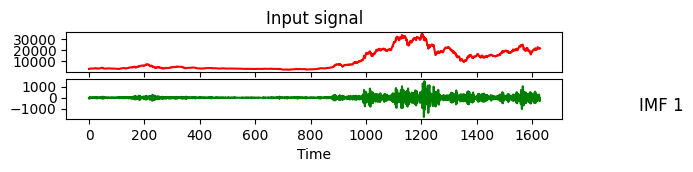

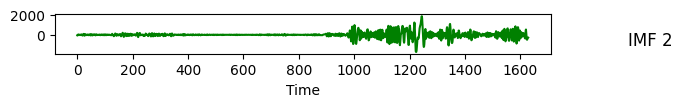

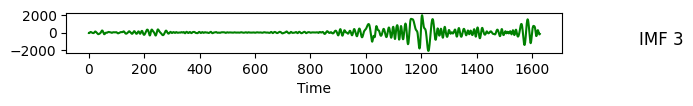

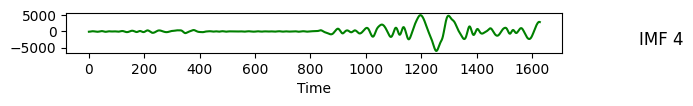

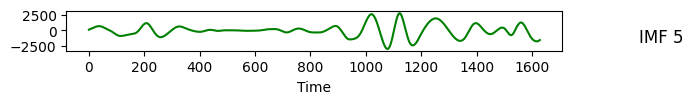

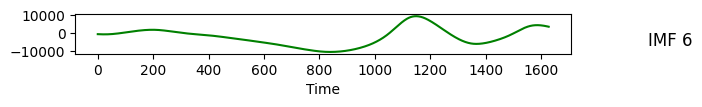

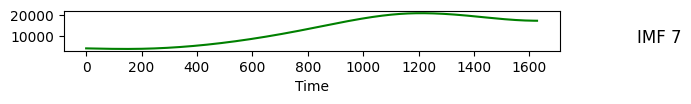

In [9]:
N = cIMFs.shape[0]+1
# Plot results
plt.subplot(N,1,1)
plt.plot(df.index, df.values, 'r')
plt.title("Input signal")
plt.xlabel("Time")

for n, imf in enumerate(cIMFs):
  plt.subplot(N,1,n+2)
  plt.plot(df.index, imf, 'g')
  plt.title("IMF "+str(n+1), x=1.2, y = 0)
  plt.xlabel("Time")
  plt.show()

In [10]:
# Tính residue
scIMF = cIMFs.sum(axis = 0).reshape(-1, 1)
residue = (np.array(df)-cIMFs.sum(axis = 0)).reshape(-1,1)

print("sIMF:", scIMF.shape)
print("Residue:", residue.shape)

sIMF: (1629, 1)
Residue: (1629, 1)


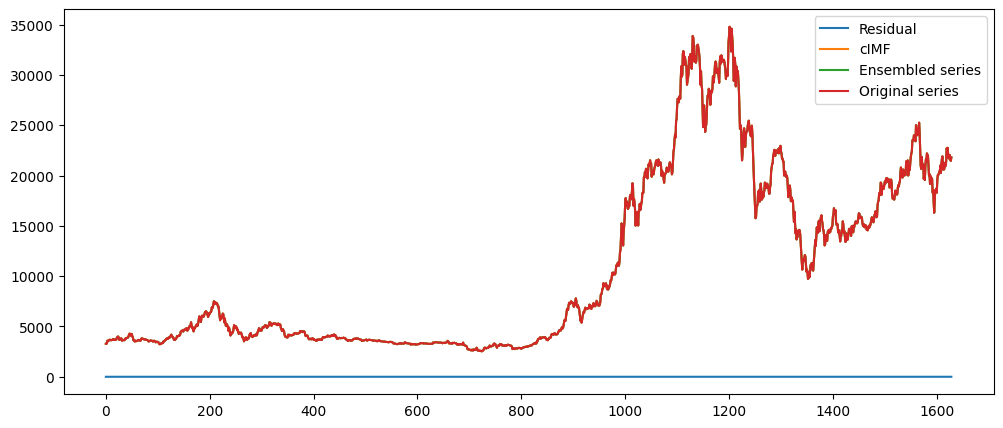

In [11]:
plt.figure(figsize=(12,5))
plt.plot(range(0,len(df)), residue)
plt.plot(range(0,len(df)), scIMF)
plt.plot(range(0,len(df)), scIMF+residue)
plt.plot(df)
plt.legend(["Residual", "cIMF", "Ensembled series", "Original series"])

plt.show()

In [12]:
# (B) LSTM
## 0. Prepocessing
# load các thư viện cần thiết
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler

In [13]:
cIMF = cIMFs.sum(axis = 0).reshape(-1, 1)+residue
cIMF

array([[ 3280.],
       [ 3280.],
       [ 3320.],
       ...,
       [21600.],
       [21450.],
       [21800.]])

In [14]:
# Scale data to 0-1
scaler = StandardScaler()
def Scaling (data):
    IMFscale = scaler.fit_transform(np.array(data))

    return IMFscale
IMFscale = Scaling(cIMF)
#train_scaled = scaler.inverse_transform(train_scaled)
#pd.DataFrame(train_scaled, columns=["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

(1629, 1)
Train:  (1140, 1)
Test:  (489, 1)


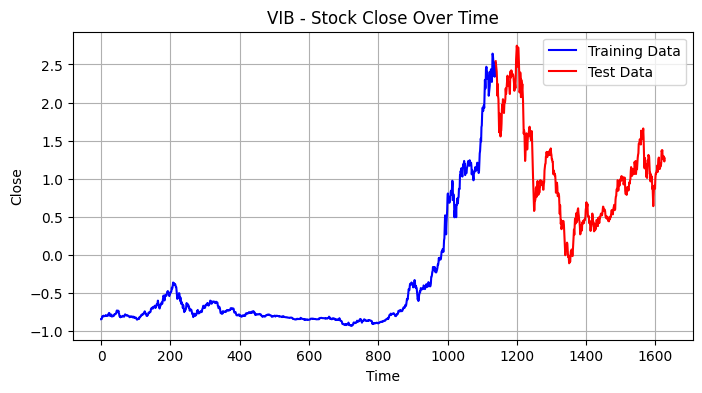

In [15]:
print(IMFscale.shape)
# Chia train test
train_size = int(0.7*IMFscale.shape[0])
test_size = int(0.3*IMFscale.shape[0])
train_data = IMFscale[:train_size].reshape(-1,1)
test_data = IMFscale[train_size:].reshape(-1,1)

print("Train: ", train_data.shape)
print("Test: ", test_data.shape)

# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size -1,  train_size+test_size), test_data, linestyle='-',  color='r', label='Test Data')


plt.title('VIB - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
trainX = []
trainY = []

n_past = 60
n_future = 1

for i in range(n_past, len(train_data) - n_future + 1):
    past_sequence = train_data[i - n_past:i, 0:train_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = train_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    trainX.append(past_sequence)
    trainY.append(future_sequence)

trainX, trainY = np.array(trainX), np.array(trainY)
print("X train: ", trainX.shape)
print("Y train: ", trainY.shape)

X train:  (1080, 60, 1)
Y train:  (1080, 1)


In [17]:
testX = []
testY = []

for i in range(n_past, len(test_data) - n_future + 1):
    past_sequence = test_data[i - n_past:i, 0:test_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = test_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    testX.append(past_sequence)
    testY.append(future_sequence)

testX, testY = np.array(testX), np.array(testY)

print("X test: ", testX.shape)
print("Y test: ", testY.shape)

X test:  (429, 60, 1)
Y test:  (429, 1)


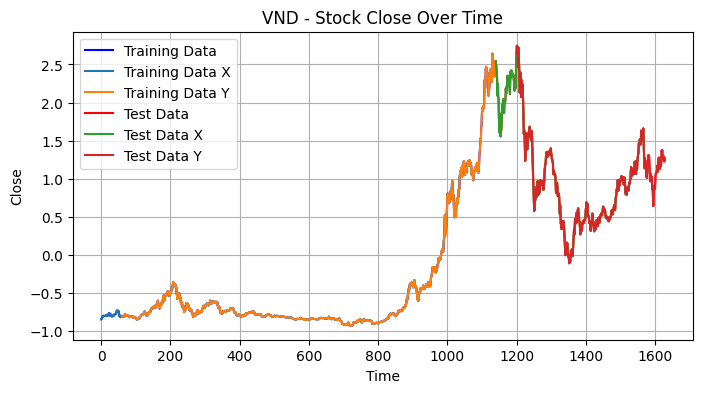

In [18]:
# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size-n_past), trainX[:,0,0], linestyle='-', label='Training Data X')
plt.plot(range(n_past,train_size), trainY[:,0], linestyle='-', label='Training Data Y')
plt.plot(range(train_size, train_size+test_size+1), test_data, linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size, train_size+test_size-n_past+1), testX[:,0,0], linestyle='-',  label='Test Data X')
plt.plot(range(train_size+n_past, train_size+test_size+1), testY[:,0], linestyle='-', label='Test Data Y')


plt.title('VND - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
## 1. Train model
# Tạo model lstm cho việc training
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mape')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# fit the model
history = model.fit(trainX, trainY, epochs=60, batch_size=4, validation_split=0.1, verbose=1)

Epoch 1/60
243/243 [==============================] - 12s 39ms/step - loss: 30.8330 - val_loss: 32.5564
Epoch 2/60
243/243 [==============================] - 7s 30ms/step - loss: 18.8890 - val_loss: 27.1998
Epoch 3/60
243/243 [==============================] - 9s 37ms/step - loss: 18.0754 - val_loss: 14.9944
Epoch 4/60
243/243 [==============================] - 8s 32ms/step - loss: 15.8000 - val_loss: 17.4418
Epoch 5/60
243/243 [==============================] - 8s 34ms/step - loss: 16.5529 - val_loss: 49.3479
Epoch 6/60
243/243 [==============================] - 9s 37ms/step - loss: 16.4431 - val_loss: 13.2504
Epoch 7/60
243/243 [==============================] - 7s 30ms/step - loss: 18.2626 - val_loss: 15.5486
Epoch 8/60
243/243 [==============================] - 9s 37ms/step - loss: 15.1848 - val_loss: 15.4571
Epoch 9/60
243/243 [==============================] - 7s 30ms/step - loss: 16.0307 - val_loss: 15.9271
Epoch 10/60
243/243 [==============================] - 9s 37ms/step - lo

In [21]:
prediction = model.predict(testX)
prediction_copies = np.repeat(prediction, train_data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred_future)

14/14 [==============================] - 1s 15ms/step
[22854.     22881.26   23372.543  22970.967  23228.979  22178.28
 23519.018  22621.129  22624.865  21884.004  21110.742  21292.852
 22063.07   21560.828  20864.498  21914.346  21468.559  21346.59
 21643.045  21127.47   20855.287  20034.998  19388.865  19551.402
 19422.717  18789.525  18240.531  18502.62   19179.492  19462.416
 19728.53   19464.361  18973.055  19329.385  19634.635  19639.268
 19702.215  19927.703  20023.357  20095.492  19777.008  19591.703
 19477.754  19388.002  19762.521  19821.598  19393.787  18746.668
 18182.969  17589.97   17046.504  16509.273  15994.657  15850.665
 16153.53   16268.438  16460.379  16998.71   17123.83   17328.69
 16941.045  17379.682  17658.748  17481.361  17100.197  17065.496
 17273.512  17101.287  17271.957  17361.     17720.045  17594.527
 17657.682  17546.213  17722.383  17700.21   17626.055  17532.094
 17292.934  17252.01   17484.346  17611.467  18201.035  18414.594
 18619.545  18642.047  19

In [22]:
train_back = scaler.inverse_transform(train_data)
test_back = scaler.inverse_transform(test_data)

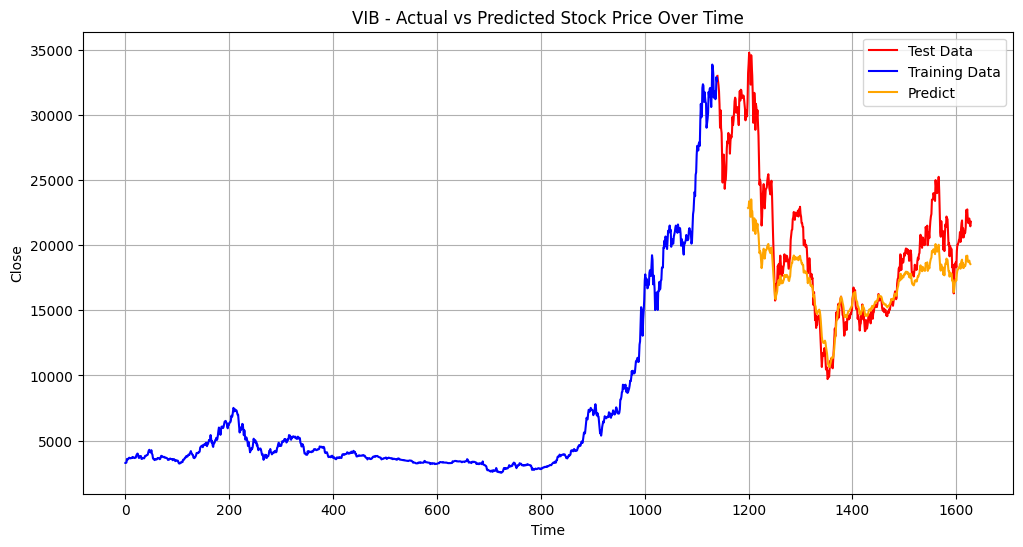

In [23]:
plt.figure(figsize=(12, 6))
n_future = 60

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
#predict_date = Test_data['Time'];
plt.plot(range(train_size+n_future-1, train_size+test_size),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# # Plot predicted values
#plt.plot( test_Date, y_pred, label='Predicted', linestyle='-',  color='b')

plt.title('VIB - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
n_past = 1
n_days_for_prediction= 60

#print(test_data.reshape(1,-1).T.shape)

test_for_forecast = test_data.reshape(1,-1).T

x_forecast = []
y_forecast = []

for i in range(n_days_for_prediction):
  # B1 Duyệt dữ liệu test n ngày gần nhất => bỏ vào x tạm
  x = np.array(test_for_forecast[(-60):])
  print(x.shape)
  x = x.T.reshape(x.shape[1], x.shape[0], 1)
  print(x.shape)

  # B2 dùng predict để chạy 1 ngày
  y = model.predict(x)
  # B3 thêm data ngày đó vào y_forecast, test_for_forecast và append x vào x_forecast
  y_c = np.repeat(y, x.shape[1], axis=-1)
  y_pr = scaler.inverse_transform(y_c)[:,0]

  x_forecast.append(x)
  y_forecast.append(y_pr)
  test_for_forecast = np.append(test_for_forecast, y).reshape(-1,1)
  print(test_for_forecast.shape)
  #test_for_forecast.append(y)
  # B4 lặp lại đến ngày thứ 60

x_forecast = np.array(x_forecast)
y_forecast = np.array(y_forecast)

(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 27ms/step
(490, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 28ms/step
(491, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 24ms/step
(492, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 25ms/step
(493, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 26ms/step
(494, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 25ms/step
(495, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 25ms/step
(496, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 26ms/step
(497, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 26ms/step
(498, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 28ms/step
(499, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 25ms/step
(500, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 24ms/step
(501, 1)
(60, 1)
(1, 60, 1)
1/1 [================

In [25]:
print(y_forecast)

[[18699.19  ]
 [17448.861 ]
 [16927.219 ]
 [16547.104 ]
 [16300.833 ]
 [16140.0625]
 [16038.417 ]
 [15979.811 ]
 [15952.239 ]
 [15946.283 ]
 [15955.045 ]
 [15973.504 ]
 [15997.967 ]
 [16025.709 ]
 [16054.728 ]
 [16083.564 ]
 [16111.187 ]
 [16136.895 ]
 [16160.251 ]
 [16181.026 ]
 [16199.146 ]
 [16214.657 ]
 [16227.691 ]
 [16238.4375]
 [16247.121 ]
 [16253.987 ]
 [16259.277 ]
 [16263.233 ]
 [16266.078 ]
 [16268.015 ]
 [16269.227 ]
 [16269.873 ]
 [16270.092 ]
 [16269.994 ]
 [16269.677 ]
 [16269.214 ]
 [16268.667 ]
 [16268.082 ]
 [16267.493 ]
 [16266.924 ]
 [16266.395 ]
 [16265.911 ]
 [16265.482 ]
 [16265.109 ]
 [16264.79  ]
 [16264.522 ]
 [16264.303 ]
 [16264.124 ]
 [16263.984 ]
 [16263.876 ]
 [16263.795 ]
 [16263.738 ]
 [16263.698 ]
 [16263.675 ]
 [16263.661 ]
 [16263.656 ]
 [16263.659 ]
 [16263.666 ]
 [16263.675 ]
 [16263.687 ]]


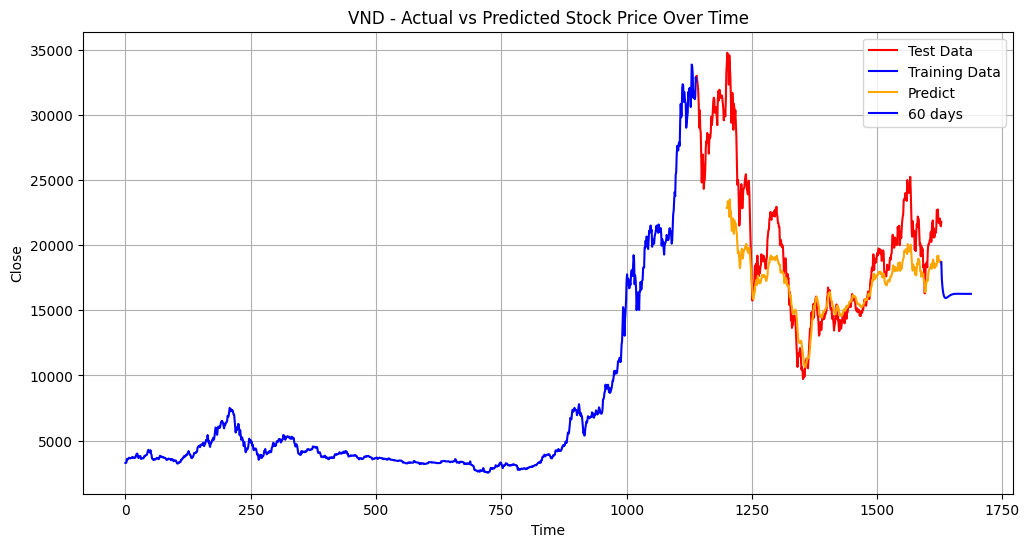

In [26]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
# Plot predict test and actual test
plt.plot(range(train_size + 60, train_size + test_size+1),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# Plot 60 days
plt.plot(range(train_size+test_size, train_size+test_size+60), y_forecast, linestyle='-', color='b', label='60 days')

plt.title('VND - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100
def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))

In [28]:
print("RSME: ", RSME(y_pred_future, test_back[60:]))
print("MAE: ", MAE(y_pred_future, test_back[60:]))
print("MAPE: ", MAPE(y_pred_future, test_back[60:]))
print("MSLR: ", MSLE(y_pred_future, test_back[60:]))

RSME:  5408.770314323424
MAE:  4135.9562440825
MAPE:  21.810914481748146
MSLR:  0.08339757432439363
